In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from eda_helpers import normality_check, count_outliers

# Exploratory Data Analysis (EDA)

### 1. Load train set and sample the dataset to a manageable size if necessary

In [29]:
data = pd.read_csv('data/data_train.csv')
data.head()

,Address,Zip,Price,Area,Room,Lon,Lat
0,"Billitonstraat 4 3, Amsterdam",1094 BC,385000.0,49,3,4.938408,52.365552
1,"Zuidelijke Wandelweg 151 PP, Amsterdam",1079 RK,930000.0,123,4,4.894206,52.338220
2,"Tweede Keucheniusstraat 8 3, Amsterdam",1051 VR,500000.0,70,3,4.869195,52.380747
3,"De Bazelhof 24, Amsterdam",1067 LZ,400000.0,107,6,4.795810,52.376916
4,"Bos en Lommerweg 360, Amsterdam",1061 DJ,475000.0,98,4,4.838520,52.379072


### 2. For supervised learning tasks, identify the target attribute

In [30]:
TARGET = 'Price'

### 3. Study each attribute and its characteristics:

1. **Name**

In [31]:
data.columns

Index(['Address', 'Zip', 'Price', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')

2. **Type (categorical, int/float, bounded/unbounded, text, structured, etc.);**

In [32]:
data_info = pd.DataFrame.from_dict(
    {
        "Price": "continuous",  # <- This is our TARGET
        "Address": "text",      # assumption: might be non-informative, because there is also longtitude and latitude data present, which might appear to be more infirmative
        "Zip": "text",          # because zip contains not only numbers, but also letters
        "Area": "continuous",
        "Room": "descrete",
        "Lon": "continuous",
        "Lat": "continuous",
    },
    orient="index",
    columns=["data_type"],
)
display(data_info.transpose())

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous


3. **Percentage of missing values;**

In [33]:
print(
    f"o {data.isna().sum().sum()} ({data.isna().sum().sum()*100/data.shape[0]*data.shape[1]:.2f}%) missing values"
)

o 3 (2.84%) missing values


Check if missing values are represented in a different way as in the description of the dataset it is stated that there are missing values.

In [34]:
# Uncomment to inspect all columns

# for column in data.columns:
#     print(f"{column}: {data[column].unique()}")

There is no missing data, that is represented in a different way.

In [35]:
df_missing_value = data.isna().sum().to_frame(name="missing values")
display(df_missing_value.transpose())

,Address,Zip,Price,Area,Room,Lon,Lat
missing values,0,0,3,0,0,0,0


In [36]:
data_info = pd.concat([data_info, df_missing_value], axis=1)
data_info

,data_type,missing values
Price,continuous,3
Address,text,0
Zip,text,0
Area,continuous,0
Room,descrete,0
Lon,continuous,0
Lat,continuous,0


In [37]:
data[data.isna().any(axis=1)]

,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244
418,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
529,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


4. **Check if there are duplicates**

In [38]:
print(
    f"o {data.duplicated().sum()} ({data.duplicated().sum()/len(data):.3f}%) duplicate values"
)

o 1 (0.001%) duplicate values


5. **Check outliers**

1. Let's check the **distribution** of the **numerical** (continuous and descrete) independent variables

In [39]:
list_numerical = []
for col in data.columns:
    if data_info['data_type'][col] == "continuous" or data_info['data_type'][col] == "descrete":
        list_numerical.append(col)

list_numerical

['Price', 'Area', 'Room', 'Lon', 'Lat']

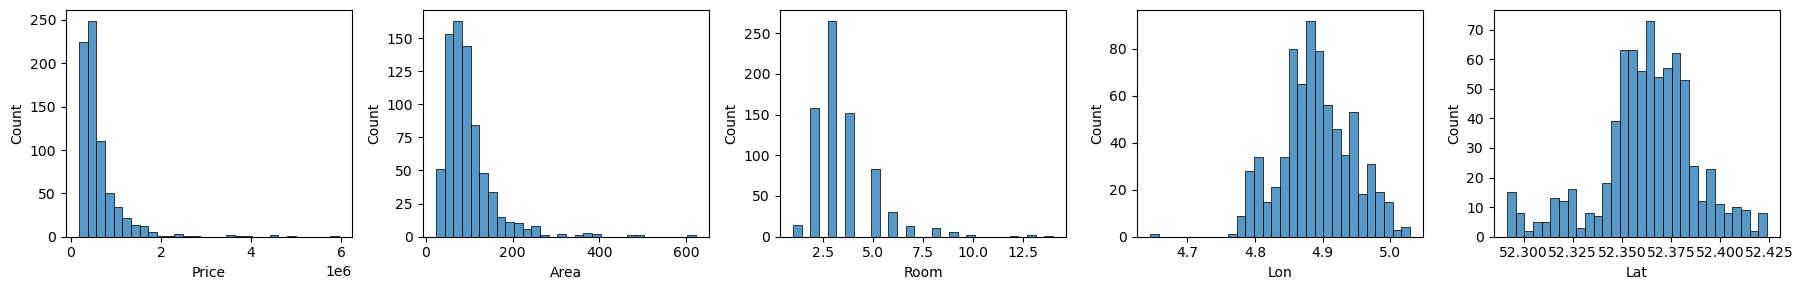

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for i, col in enumerate(list_numerical):
    plot = sns.histplot(ax=axes.flatten()[i], x = data[col], bins = 30)

plt.tight_layout() 

In [41]:
# Create a 'Distribution' column with default value
data_info['distribution'] = 'not applicable'
normality_check(data, data_info, data.columns)
data_info


,data_type,missing values,distribution
Price,continuous,3,not normal
Address,text,0,not applicable
Zip,text,0,not applicable
Area,continuous,0,not normal
Room,descrete,0,not normal
Lon,continuous,0,normal
Lat,continuous,0,not normal


In [42]:
# Specify the type on non-Gaussian distributions:

data_info.loc[['Price', 'Area', 'Room'], 'distribution'] = 'right_skewed'
data_info.loc['Lat', 'distribution'] = 'heavy_tailed'

data_info

,data_type,missing values,distribution
Price,continuous,3,right_skewed
Address,text,0,not applicable
Zip,text,0,not applicable
Area,continuous,0,right_skewed
Room,descrete,0,right_skewed
Lon,continuous,0,normal
Lat,continuous,0,heavy_tailed


Price, Area, and Room are right scewed destributions, that is why simple ± 3std rule can not be applied to detect outliers. Instead, we can apply Q3 +1.5(IQR) rule. Here we will use a custom function, that defines a type of distribution and applies correct formula to detect outliers:

In [43]:
count_outliers(data, data_info, data.columns, show_details = True)

Impossible to define outliers for Address data: data is not in [continuous, descrete]
Impossible to define outliers for Zip data: data is not in [continuous, descrete]
o 61 datapoints with Price > 1196250.0


,Address,Zip,Price,Area,Room,Lon,Lat
7,"Prinsengracht 416 A, Amsterdam",1016 JC,1275000.0,165,5,4.882122,52.366395
9,"Noordermarkt 32 A, Amsterdam",1015 MZ,1200000.0,105,4,4.886034,52.379546
12,"Singel 318, Amsterdam",1016 AE,4900000.0,623,13,4.887869,52.371039
22,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928
33,"Reguliersgracht 87, Amsterdam",1017 LN,1450000.0,124,5,4.896425,52.360892
...,...,...,...,...,...,...,...
683,"Colenbranderhof 30, Amsterdam",1065 BG,1650000.0,235,7,4.820848,52.358631
686,"Valeriusstraat 148 Hs, Amsterdam",1075 GE,1775000.0,177,9,4.865595,52.353408
687,"Keizersgracht 171 F, Amsterdam",1016 DP,1625000.0,199,6,4.885830,52.374742
688,"Prinseneiland 545, Amsterdam",1013 EC,1950000.0,258,4,4.887444,52.385346


o 41 datapoints with Area > 190.0


,Address,Zip,Price,Area,Room,Lon,Lat
11,"Noorderakerweg 124, Amsterdam",1069 LW,950000.0,226,7,4.776234,52.349215
12,"Singel 318, Amsterdam",1016 AE,4900000.0,623,13,4.887869,52.371039
35,"Ruysdaelkade 109, Amsterdam",1072 AN,1650000.0,232,9,4.887183,52.355020
39,"Gerrit van der Veenstraat 145 B*, Amsterdam",1077 DZ,1625000.0,257,9,4.869761,52.348636
46,"Utrechtsedwarsstraat 4, Amsterdam",1017 WG,1700000.0,194,6,4.896542,52.360937
60,"Willem Augustinstraat 179, Amsterdam",1061 MJ,975000.0,221,5,4.838629,52.374910
74,"Borneokade 70, Amsterdam",1019 AW,1750000.0,246,8,4.909819,52.368653
85,"Sophialaan 45, Amsterdam",1075 BM,3500000.0,374,7,4.857608,52.352366
136,"Vondelstraat 51 hs, Amsterdam",1054 GJ,3925000.0,319,7,4.875471,52.361571
144,"Singel 146 A, Amsterdam",1015 AG,3500000.0,348,8,4.889816,52.375532


o 66 datapoints with Room > 5.5


,Address,Zip,Price,Area,Room,Lon,Lat
3,"De Bazelhof 24, Amsterdam",1067 LZ,400000.0,107,6,4.795810,52.376916
11,"Noorderakerweg 124, Amsterdam",1069 LW,950000.0,226,7,4.776234,52.349215
12,"Singel 318, Amsterdam",1016 AE,4900000.0,623,13,4.887869,52.371039
35,"Ruysdaelkade 109, Amsterdam",1072 AN,1650000.0,232,9,4.887183,52.355020
39,"Gerrit van der Veenstraat 145 B*, Amsterdam",1077 DZ,1625000.0,257,9,4.869761,52.348636
...,...,...,...,...,...,...,...
672,"Baarsjesweg 313 H, Amsterdam",1058 AH,1499000.0,245,8,4.854662,52.358204
683,"Colenbranderhof 30, Amsterdam",1065 BG,1650000.0,235,7,4.820848,52.358631
686,"Valeriusstraat 148 Hs, Amsterdam",1075 GE,1775000.0,177,9,4.865595,52.353408
687,"Keizersgracht 171 F, Amsterdam",1016 DP,1625000.0,199,6,4.885830,52.374742


o 1 datapoints with Lon < 4.730323562198041


,Address,Zip,Price,Area,Room,Lon,Lat
504,"Lijnbaansstraat 7, Amsterdam",1016 ST,950000.0,133,7,4.644819,52.37806


o No outliers in Lat


,Address,Zip,Price,Area,Room,Lon,Lat


- There is one data point in Area feature, that seems to be a data mistake: in row 393 there is only 1 room per 258 sq.m. which is too much for a house (it is predefined that this dataset is about residential houses, not warehouses, shops, etc.)
- All other outliers are just big expensive houses.
- There is an outlier below 3std in Longtitude. Lel's plot Lat vs Lon and see what the map of houses looks like:

In [44]:
data_info['n outliers'] = 0
data_info.loc['Area', 'n outliers'] = 1

<Axes: xlabel='Lat', ylabel='Lon'>

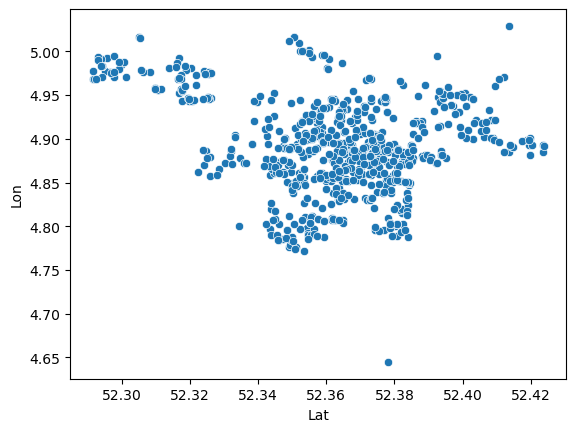

In [46]:
sns.scatterplot(x=data['Lat'], y=data['Lon'])

The point at the bottom of the plot is a longitude outlier. 

There is one more point, that was not included nither to longitude nor to latitude outliers, looks like another outlier though: the one in the top right corner. Longitude might be close to upper 3std border, latitude fits inside 3std. Lets check this point:

In [47]:
data.loc[lambda x: x["Lon"] > 5, ("Lat", 'Lon')]

,Lat,Lon
38,52.351935,5.009082
108,52.305075,5.016522
240,52.350513,5.016555
270,52.350513,5.016555
280,52.349139,5.012134
378,52.305296,5.015376
389,52.354845,5.001384
423,52.413550,5.029122
463,52.353136,5.000973
523,52.352324,5.000011


In [48]:
# how far is the point (423) from the mean latitude (based on formula x = mean + n*std)

n = (5.029122 - data['Lon'].mean()) / np.std(data['Lon'])
n

2.6338021298188536

The value is close to 3, which means that this point is in 5% minority of data, that lies behind ±2std. Can easily be classified as outlier counting the fact, that also latitude is the highest for this longitude sector (>5).

In [49]:
data_info.loc['Lon', 'n outliers'] = 2

data_info.to_parquet("./data/data_info.parquet")

data_info.transpose()

,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,1,0,2,0


2. Check text data (Address and ZIP)

In [50]:
data['Address'].value_counts()

Address
Ringdijk, Amsterdam                         2
Quashibastraat, Amsterdam                   2
Slatuinenweg 21, Amsterdam                  1
Tweede Oosterparkstraat 188 2, Amsterdam    1
Spadinalaan 53, Amsterdam                   1
                                           ..
Hamontstraat 59, Amsterdam                  1
Kanaalstraat 204 H, Amsterdam               1
Paramariboplein 67 bel, Amsterdam           1
Achillesstraat 113 2, Amsterdam             1
Van Gentstraat 6 1, Amsterdam               1
Name: count, Length: 737, dtype: int64

There are 737 unique addresses out of 739 datapoints. That will not give a lot of information in terms of prediction. Let's check zip codes:

In [51]:
data['Zip'].value_counts()

Zip
1075 XR    5
1060 SC    3
1060 RZ    3
1011 AW    3
1095 MD    3
          ..
1058 AR    1
1076 RA    1
1019 AL    1
1053 TP    1
1055 PE    1
Name: count, Length: 679, dtype: int64

It looks slightly better: there are some houses with the same zip codes and there could be dependancy between zip and price of the house. However, if we investigate the princip of zip codes formation, it is easy to discover, that main regions of the city are marked with 4 numbers, and subregions, which usually include just a couple of houses, are marked with 2 letters. When first 2 digits are 1 and 0, it means the house is in Amsterdam. Even though the dataset is about this city, there are also zip codes, which start with 11 - that is a Zuidost area, which is a bit futher from the city. The assumption is that there might be less clusters (and thus more predictable), if use only 4 digits instead of 4 digits + 2 letters. Let's try to separate them:

In [52]:
data['Zip num'] = np.nan
data['Zip letters'] = np.nan
for row in range(data.shape[0]):
    data.loc[row, 'Zip num'] = data.loc[row, 'Zip'][:-3]
    data.loc[row, 'Zip letters'] = data.loc[row, 'Zip'][5:]

In [53]:
data['Zip num'].value_counts()

Zip num
1017    26
1055    24
1053    21
1102    21
1058    19
        ..
1086     3
1014     3
1109     2
1028     2
1022     1
Name: count, Length: 70, dtype: int64

The assumption is accepted: there are 9 times less clusters when using only numbers of zip code. This hypothesis will be tested when different models will be applied.

### 4. Identify the promising transformations that may be applied.

1. Divide Zip to numbers and letters or make a deeper research to discover another princip for clustering Zip codes.
2. Add price per square meter, as in the world of real estate that is more important than a price of a house.
3. Having coordinates of latitude and longitude, it is posible to define a 'center' point as a city center, where the houses are usually more expencive, and calculate distance to every datapoint as a vector.
4. Address data in original format is not informative and needs to be changed or removed.

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

